## Applies COMMOT to HVGs, SVGs, and unfiltered expression data set for human brain ST 

- matches cell barcodes in seurat and HVG/SVG matrices
- creates anndata object for COMMOT input
- runs COMMOT on different LR filtered SVG/HVG/unfiltered genes

author: @emilyekstrum
1/20/26

In [99]:
import pandas as pd
import numpy as np
import scanpy as sc
import commot as ct
import os
import pyreadr
import rpy2
from rpy2.robjects.packages import importr
import anndata as ad
import copy
from collections import defaultdict
from scipy import sparse
import math
import matplotlib.pyplot as plt

np.random.seed(42)

In [125]:
# utils
# SVG/HVG filtering
def receptor_in_set(rec, geneset):
    return any(p in geneset for p in str(rec).split("_"))

def split_parts(x):
    if pd.isna(x):
        return []
    # if receptor stored as list/tuple/set
    if isinstance(x, (list, tuple, set)):
        parts = []
        for y in x:
            parts.extend(str(y).split("_"))
        return parts
    return str(x).split("_")

def receptor_parts(rec: str):
    # heteromeric receptors are encoded as "A_B_C"
    return str(rec).split("_")

def receptor_in_var(rec: str) -> bool:
    parts = receptor_parts(rec)
    return any(p in varset for p in parts)

def receptor_in_set(rec: str, geneset: set) -> bool:
    parts = receptor_parts(rec)
    return any(p in geneset for p in parts)


def pair_prevalence_ok(df):
    lig_ok = df[LIG].map(lambda g: pct_expr.get(g, 0) >= min_pct)
    rec_ok = df[REC].map(lambda r: any(pct_expr.get(p, 0) >= min_pct for p in receptor_parts(r)))
    return df[lig_ok & rec_ok].copy()


def commot_inventory(ad):
    return {
        "n_obs": ad.n_obs,
        "n_vars": ad.n_vars,
        "n_obsp": len(ad.obsp.keys()),
        "obsp_keys_head": list(ad.obsp.keys())[:15],
        "uns_keys_head": list(ad.uns.keys())[:15],
    }

def split_pathway_lr_keys(ad):
    keys = list(ad.obsp.keys())
    # pathway matrices typically have much larger nnz and fewer keys overall;
    # also often contain "pathway" or "sum" in key names (depends on version).
    path_keys = [k for k in keys if ("path" in k.lower()) or ("sum" in k.lower())]
    # fallback: if that fails, treat everything as LR and you can manually adjust later
    if len(path_keys) == 0:
        path_keys = []
    lr_keys = [k for k in keys if k not in path_keys]
    return path_keys, lr_keys

def rank_obsp_by_total(ad, keys=None):
    if keys is None:
        keys = list(ad.obsp.keys())
    rows = []
    for k in keys:
        M = ad.obsp[k]
        total = M.sum() if sparse.issparse(M) else np.sum(M)
        rows.append((k, float(total)))
    rows.sort(key=lambda x: x[1], reverse=True)
    return rows

def add_sender_receiver(ad, key, prefix):
    M = ad.obsp[key]
    out = np.array(M.sum(axis=1)).ravel()
    inn = np.array(M.sum(axis=0)).ravel()
    ad.obs[f"{prefix}__out"] = out
    ad.obs[f"{prefix}__in"] = inn
    return out, inn


def top_totals_table(results_dict, top_n=20):
    # get keys from first result
    ref_name = list(results_dict.keys())[0]
    ref = results_dict[ref_name]
    pk, lk = split_pathway_lr_keys(ref)
    keys = pk if len(pk) > 0 else lk

    # rank by totals in reference
    ref_rank = rank_obsp_by_total(ref, keys)[:top_n]
    top_keys = [k for k, _ in ref_rank]

    out = pd.DataFrame(index=top_keys)
    for name, ad in results_dict.items():
        vals = []
        for k in top_keys:
            if k in ad.obsp:
                M = ad.obsp[k]
                vals.append(float(M.sum() if sparse.issparse(M) else np.sum(M)))
            else:
                vals.append(0.0)
        out[name] = vals
    return out

# look at significance of top pathways in real vs null model
def pathway_significance(real_ad, null_ads, top_n=10):
    pk, lk = split_pathway_lr_keys(real_ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top_paths = [k for k, _ in rank_obsp_by_total(real_ad, keys_to_rank)[:top_n]]

    results = []
    for path in top_paths:
        real_M = real_ad.obsp[path]
        real_total = real_M.sum() if sparse.issparse(real_M) else np.sum(real_M)

        null_totals = []
        for null_ad in null_ads:
            null_M = null_ad.obsp.get(path)
            if null_M is not None:
                null_total = null_M.sum() if sparse.issparse(null_M) else np.sum(null_M)
                null_totals.append(null_total)
            else:
                null_totals.append(0.0)

        mean_null = np.mean(null_totals)
        std_null = np.std(null_totals)
        z_score = (real_total - mean_null) / std_null if std_null > 0 else float('inf')

        results.append({
            "pathway": path,
            "real_total": real_total, # total OT mass in real data
            "mean_null_total": mean_null, # mean total OT mass in null data
            "std_null_total": std_null, # std dev of total OT mass in null data
            "z_score": z_score 
        })

    return pd.DataFrame(results)


def snapshot_keys(ad):
    return {
        "uns": set(ad.uns.keys()),
        "obsm": set(ad.obsm.keys()),
        "obsp": set(ad.obsp.keys()),
    }

def cleanup_added(ad, before):
    for k in set(ad.uns.keys()) - before["uns"]:
        del ad.uns[k]
    for k in set(ad.obsm.keys()) - before["obsm"]:
        del ad.obsm[k]
    for k in set(ad.obsp.keys()) - before["obsp"]:
        del ad.obsp[k]

def sum_pathways_from_new_obsp(ad, new_obsp_keys, db="cellchat"):
    """
    when pathway_sum=True, COMMOT will write some pathway-level
    matrices to obsp in addition to LR-pair matrices.
    grab sums for anything newly added whose key starts with commot-<db>-.
    """
    totals = {}
    prefix = f"commot-{db}-"
    for k in new_obsp_keys:
        if not k.startswith(prefix):
            continue
        mat = ad.obsp[k]
        # mat is usually sparse; .sum() is fast
        totals[k] = float(mat.sum())
    return totals

def _as_lr_df(obj, lig_col="ligand", rec_col="receptor", uns_key=None):
    """
    Convert obj (pd.DataFrame or AnnData) -> LR DataFrame with ligand/receptor columns.
    
    If obj is AnnData, tries:
      - obj.uns[uns_key] if provided
      - else: looks for the first DataFrame in obj.uns that contains lig_col & rec_col
    """
    # Case 1: already a DataFrame
    if isinstance(obj, pd.DataFrame):
        return obj

    # Case 2: AnnData
    try:
        import anndata as ad
        AnnData = ad.AnnData
    except Exception:
        AnnData = ()

    if AnnData and isinstance(obj, AnnData):
        # If user specifies where the LR table is
        if uns_key is not None:
            df = obj.uns.get(uns_key, None)
            if df is None:
                raise KeyError(f"AnnData.uns does not contain key '{uns_key}'. Keys: {list(obj.uns.keys())}")
            if not isinstance(df, pd.DataFrame):
                raise TypeError(f"AnnData.uns['{uns_key}'] is {type(df)}, not a pandas DataFrame.")
            return df

        # Otherwise, try to find a suitable df in .uns
        for k, v in obj.uns.items():
            if isinstance(v, pd.DataFrame) and lig_col in v.columns and rec_col in v.columns:
                return v

        raise ValueError(
            f"Could not find an LR DataFrame in AnnData.uns with columns "
            f"'{lig_col}' and '{rec_col}'. Available uns keys: {list(obj.uns.keys())}"
        )

    raise TypeError(f"Expected pandas.DataFrame or AnnData, got {type(obj)}")


def compare_lr_sets(sets_dict, lig_col="ligand", rec_col="receptor", uns_key=None):
    """
    Compare LR sets across entries in sets_dict.
    Each entry can be a DataFrame (preferred) or an AnnData containing an LR DataFrame in .uns.
    """
    pair_sets = {}

    for name, obj in sets_dict.items():
        df = _as_lr_df(obj, lig_col=lig_col, rec_col=rec_col, uns_key=uns_key)

        pairs = set()
        for _, row in df.iterrows():
            lig = row[lig_col]
            rec = row[rec_col]
            pairs.add((str(lig), str(rec)))

        pair_sets[name] = pairs

    # Example summary: sizes + Jaccard overlap matrix
    names = list(pair_sets.keys())
    sizes = {n: len(pair_sets[n]) for n in names}

    jaccard = pd.DataFrame(index=names, columns=names, dtype=float)
    for a in names:
        for b in names:
            A, B = pair_sets[a], pair_sets[b]
            jaccard.loc[a, b] = (len(A & B) / len(A | B)) if (A or B) else 1.0

    return {"sizes": sizes, "jaccard": jaccard, "pair_sets": pair_sets}


# check differences between LR sets for SVG, HVG, unfiltered
# def compare_lr_sets(sets_dict):
#     lr_sets = {}
#     for name, df in sets_dict.items():
#         pairs = set()
#         for _, row in df.iterrows():
#             lig = row[LIG]
#             rec = row[REC]
#             pairs.add((lig, rec))
#         lr_sets[name] = pairs

#     all_names = list(lr_sets.keys())
#     n = len(all_names)

#     comparison = pd.DataFrame(index=all_names, columns=all_names, dtype=int)

#     for i in range(n):
#         for j in range(n):
#             set_i = lr_sets[all_names[i]]
#             set_j = lr_sets[all_names[j]]
#             intersection = set_i.intersection(set_j)
#             comparison.iloc[i, j] = len(intersection)

#     return comparison

### Prepare data for COMMOT input
- align by barcode 
- get non negative expression matrix

In [83]:
# load in human data HVGs and SVGs - using unLR filtered data
# sorted by p value in ascending order
hvg_gene_cell_mat = os.path.join("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/hvgs", "human_hvg_gene_cell_matrix.csv")
svg_gene_cell_mat = os.path.join("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/svgs", "nnSVG_human_svg_gene_cell_matrix.csv")

In [84]:
# check first lines of HVG and SVG gene cell matrices
hvg_df = pd.read_csv(hvg_gene_cell_mat, index_col=0)
svg_df = pd.read_csv(svg_gene_cell_mat, index_col=0)

hvg_df.head() # gene by spot matrix
#svg_df.head()

,AAACAAGTATCTCCCA.1,AAACAATCTACTAGCA.1,AAACACCAATAACTGC.1,AAACAGCTTTCAGAAG.1,AAACAGGGTCTATATT.1,AAACAGTGTTCCTGGG.1,AAACATTTCCCGGATT.1,AAACCCGAACGAAATC.1,AAACCGGGTAGGTACC.1,AAACCGTTCGTCCAGG.1,...,TTGTGGTGGTACTAAG.1,TTGTGTATGCCACCAA.1,TTGTGTTTCCCGAAAG.1,TTGTTAGCAAATTCGA.1,TTGTTCAGTGTGCTAC.1,TTGTTGTGTGTCAAGA.1,TTGTTTCACATCCAGG.1,TTGTTTCATTAGTCTA.1,TTGTTTGTATTACACG.1,TTGTTTGTGTAAATTC.1
MBP,1.609438,2.197225,4.709530,2.639057,3.401197,3.73767,1.386294,0.000000,1.791759,4.477337,...,1.609438,3.178054,2.890372,2.484907,1.791759,2.995732,3.89182,4.110874,3.850148,0.000000
PLP1,1.386294,0.693147,3.871201,1.609438,3.218876,3.76120,1.386294,1.098612,2.197225,3.988984,...,0.693147,1.945910,1.791759,1.098612,1.609438,1.098612,4.59512,3.610918,2.890372,1.098612
IGKC,1.098612,0.000000,0.693147,2.197225,0.693147,0.00000,2.079442,0.000000,1.098612,0.000000,...,1.098612,0.000000,0.000000,0.693147,0.693147,1.386294,0.00000,1.791759,0.000000,0.000000
NPY,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.693147,...,0.693147,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000
GFAP,0.000000,2.302585,2.995732,0.000000,1.386294,2.70805,0.000000,0.693147,1.386294,3.044522,...,1.386294,0.693147,2.079442,0.000000,0.000000,0.000000,1.94591,3.583519,2.564949,0.693147


In [85]:
# convert matrices to gene lists
SVG = set(svg_df.index.tolist())
HVG = set(hvg_df.index.tolist())

In [86]:
# look at lists
print(f"First 10 HVGs: {list(HVG)[:10]}")
print(f"First 10 SVGs: {list(SVG)[:10]}")

First 10 HVGs: ['POLRMT', 'STC2', 'KPTN', 'AC104825.1', 'PLA2G6', 'TBC1D14', 'MKRN2', 'IDI1', 'RAB23', 'CYREN']
First 10 SVGs: ['POLRMT', 'TBC1D14', 'IDI1', 'SSX2IP', 'MRPS25', 'GORASP2', 'HNRNPU', 'SYNM', 'MTMR10', 'EXTL2']


In [87]:
# get non negative expression and coordiantes from human seurat

import rpy2.robjects as ro
from rpy2.robjects import pandas2ri

# load in seurat object
ro.r('library(Seurat)')
ro.r('obj <- readRDS("/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/seurat_objs/humanbrain_seurat.rds")')

In [7]:
# look for images slot
print(ro.r('head(colnames(obj@meta.data), 50)'))  # show first 50 meta columns

 [1] "orig.ident"        "nCount_RNA"        "nFeature_RNA"     
 [4] "...1"              "imagerow"          "imagecol"         
 [7] "Manual.annotation" "percent.mt"        "nCount_SCT"       
[10] "nFeature_SCT"     



In [88]:
# get seurat barcodes
seurat_barcodes = list(ro.r('rownames(obj@meta.data)'))
seurat_barcodes = [str(x) for x in seurat_barcodes]

print("Seurat n spots:", len(seurat_barcodes))
print("CSV n spots:", svg_df.shape[1])

Seurat n spots: 2897
CSV n spots: 2897


In [89]:
# map csv columns to seurat barcodes by order
assert svg_df.shape[1] == len(seurat_barcodes), "Counts differ —> can't map by order"

# rename csv columns to seurat barcodes
svg_df.columns = seurat_barcodes
hvg_df.columns = seurat_barcodes

In [90]:
# map csv columns to seurat barcodes by order
assert svg_df.shape[1] == len(seurat_barcodes), "Counts differ —> can't map by order"

# rename csv columns to seurat barcodes
svg_df.columns = seurat_barcodes
hvg_df.columns = seurat_barcodes

In [91]:
# columns are available in the metadata
available_cols = list(ro.r('colnames(obj@meta.data)'))
print("Available metadata columns:")
for col in available_cols:
    print(f"  {col}")

# check for imagecol and imagerow or x and y
desired_cols = ['cell_id', 'imagecol', 'imagerow', 'x', 'y']
existing_cols = [col for col in desired_cols if col in available_cols]
print(f"\nCoordinate cols: {existing_cols}")

Available metadata columns:
  orig.ident
  nCount_RNA
  nFeature_RNA
  ...1
  imagerow
  imagecol
  Manual.annotation
  percent.mt
  nCount_SCT
  nFeature_SCT

Coordinate cols: ['imagecol', 'imagerow']


In [92]:
# get meta.data with rownames kept as a column
cols_to_select = ['"barcode"']  # include barcode
for col in existing_cols:
    cols_to_select.append(f'"{col}"')

col_selection = ', '.join(cols_to_select)
print(f"Selecting columns: {col_selection}")

r_command = f'''
md <- obj@meta.data
md$barcode <- rownames(md)
md[, c({col_selection})]
'''

md = ro.r(r_command)
md = pandas2ri.rpy2py(md)

# check types 
md["barcode"] = md["barcode"].astype(str)

# process cell_id if it exists
if 'cell_id' in md.columns:
    md["cell_id"] = md["cell_id"].astype(str)
    md = md.dropna(subset=["cell_id"])

print(f"\nMetadata shape: {md.shape}")
print(f"Metadata columns: {list(md.columns)}")
print("\nFirst few rows:")
print(md.head())

Selecting columns: "barcode", "imagecol", "imagerow"

Metadata shape: (2897, 3)
Metadata columns: ['barcode', 'imagecol', 'imagerow']

First few rows:
                               barcode    imagecol    imagerow
AAACAAGTATCTCCCA-1  AAACAAGTATCTCCCA-1  440.639079  381.098123
AAACAATCTACTAGCA-1  AAACAATCTACTAGCA-1  259.630972  126.327637
AAACACCAATAACTGC-1  AAACACCAATAACTGC-1  183.078314  427.767792
AAACAGCTTTCAGAAG-1  AAACAGCTTTCAGAAG-1  152.700275  341.269139
AAACAGGGTCTATATT-1  AAACAGGGTCTATATT-1  164.941500  362.916304


In [93]:
# check matches between svg spot ids and meta data cell ids/barcodes
spot_ids_csv = pd.Index(svg_df.columns.astype(str))

# check matches with barcodes (should always work)
n_match_barcode = spot_ids_csv.isin(pd.Index(md["barcode"])).sum()
print(f"CSV -> barcode matches: {n_match_barcode} of {len(spot_ids_csv)}")

# check matches with cell_id if it exists
if 'cell_id' in md.columns:
    n_match_cellid = spot_ids_csv.isin(pd.Index(md["cell_id"])).sum()
    print(f"CSV -> cell_id matches: {n_match_cellid} of {len(spot_ids_csv)}")
else:
    print("cell_id column not available in metadata")

CSV -> barcode matches: 2897 of 2897
cell_id column not available in metadata


In [94]:
# show renamed svg spot ids
print(pd.Index(svg_df.columns.astype(str))[:20].tolist())

# check overlap between seurat barcodes and csv barcodes
seurat_barcodes = pd.Index([str(x) for x in ro.r('colnames(obj)')])
csv_barcodes = pd.Index(svg_df.columns.astype(str))

print("Seurat n:", len(seurat_barcodes))
print("CSV n:", len(csv_barcodes))
print("Overlap:", len(seurat_barcodes.intersection(csv_barcodes)))
print("Seurat example:", seurat_barcodes[:5].tolist())

['AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1', 'AAACACCAATAACTGC-1', 'AAACAGCTTTCAGAAG-1', 'AAACAGGGTCTATATT-1', 'AAACAGTGTTCCTGGG-1', 'AAACATTTCCCGGATT-1', 'AAACCCGAACGAAATC-1', 'AAACCGGGTAGGTACC-1', 'AAACCGTTCGTCCAGG-1', 'AAACCTAAGCAGCCGG-1', 'AAACCTCATGAAGTTG-1', 'AAACGAAGAACATACC-1', 'AAACGAGACGGTTGAT-1', 'AAACGGGCGTACGGGT-1', 'AAACGGTTGCGAACTG-1', 'AAACTCGGTTCGCAAT-1', 'AAACTCGTGATATAAG-1', 'AAACTGCTGGCTCCAA-1', 'AAACTTAATTGCACGC-1']
Seurat n: 2897
CSV n: 2897
Overlap: 2897
Seurat example: ['AAACAAGTATCTCCCA-1', 'AAACAATCTACTAGCA-1', 'AAACACCAATAACTGC-1', 'AAACAGCTTTCAGAAG-1', 'AAACAGGGTCTATATT-1']


In [95]:
# get coordinates
coords = ro.r('''
md <- obj@meta.data
md[, c("imagecol","imagerow")]
''')
coords = pandas2ri.rpy2py(coords)
coords.index = coords.index.astype(str)
coords.columns = ["x", "y"]  


print(coords.head()) # cell ID by location

                             x           y
AAACAAGTATCTCCCA-1  440.639079  381.098123
AAACAATCTACTAGCA-1  259.630972  126.327637
AAACACCAATAACTGC-1  183.078314  427.767792
AAACAGCTTTCAGAAG-1  152.700275  341.269139
AAACAGGGTCTATATT-1  164.941500  362.916304


In [96]:
# get counts
expr_df = ro.r('''
mat <- NULL
try({ mat <- GetAssayData(obj, assay="SCT", slot="counts") }, silent=TRUE)
if (is.null(mat)) {
  try({ mat <- GetAssayData(obj, assay="SCT", layer="counts") }, silent=TRUE)
}
if (is.null(mat)) stop("Couldn't access SCT counts.")
as.data.frame(as.matrix(mat))
''')
expr_df = pandas2ri.rpy2py(expr_df)
expr_df.index = expr_df.index.astype(str) # genes
expr_df.columns = expr_df.columns.astype(str)  # barcodes

print("expr_df shape (genes x spots):", expr_df.shape)
print(expr_df.head())  # first 5 spots

expr_df shape (genes x spots): (17650, 2897)
            AAACAAGTATCTCCCA-1  AAACAATCTACTAGCA-1  AAACACCAATAACTGC-1  \
AL627309.1                 0.0                 0.0                 0.0   
AL669831.5                 0.0                 0.0                 0.0   
LINC00115                  0.0                 0.0                 0.0   
FAM41C                     0.0                 0.0                 0.0   
AL645608.1                 0.0                 0.0                 0.0   

            AAACAGCTTTCAGAAG-1  AAACAGGGTCTATATT-1  AAACAGTGTTCCTGGG-1  \
AL627309.1                 0.0                 0.0                 0.0   
AL669831.5                 0.0                 0.0                 0.0   
LINC00115                  0.0                 0.0                 0.0   
FAM41C                     0.0                 0.0                 0.0   
AL645608.1                 0.0                 0.0                 0.0   

            AAACATTTCCCGGATT-1  AAACCCGAACGAAATC-1  AAACCGGGTAGGT

In [97]:
# align by barcodes
common = csv_barcodes.intersection(expr_df.columns).intersection(coords.index)
print("Common spots:", len(common))

# subset to common spots
expr_df = expr_df.loc[:, common]
coords_sub = coords.loc[common]

# nonnegative expression for COMMOT
expr_df = np.log1p(expr_df)

# spots x genes
spot_gene_mat = expr_df.T
print("Spots by gene shape:", spot_gene_mat.shape)

Common spots: 2897
Spots by gene shape: (2897, 17650)


In [100]:
# build AnnData object for COMMOT

adata = ad.AnnData(X=spot_gene_mat.values)
adata.obs_names = spot_gene_mat.index.astype(str)
adata.var_names = spot_gene_mat.columns.astype(str)
adata.obsm["spatial"] = coords_sub.loc[adata.obs_names, ["x","y"]].values

print("adata:", adata.shape)
print("spatial:", adata.obsm["spatial"].shape)
print("X min:", adata.X.min())

adata: (2897, 17650)
spatial: (2897, 2)
X min: 0.0


### Filter LR pairs with CellChat

In [101]:
# get human LR pairs from CellChat
df_lr = ct.pp.ligand_receptor_database(database="CellChat", species="human")

# filter for LR pairs present in data
df_lr_expr = ct.pp.filter_lr_database(df_lr, adata, heteromeric=True, heteromeric_delimiter="_",
                                      heteromeric_rule="min", filter_criteria="min_cell_pct",
                                      min_cell_pct=0.05)


df_lr_svg = df_lr_expr[df_lr_expr.iloc[:,0].isin(SVG) | df_lr_expr.iloc[:,1].apply(lambda r: receptor_in_set(r, SVG))].copy()
df_lr_hvg = df_lr_expr[df_lr_expr.iloc[:,0].isin(HVG) | df_lr_expr.iloc[:,1].apply(lambda r: receptor_in_set(r, HVG))].copy()

# LR df for unfiltered data
df_lr_unfiltered = ct.pp.filter_lr_database(df_lr, adata, heteromeric=True, heteromeric_delimiter="_",
                                      heteromeric_rule="min", filter_criteria="none")

In [102]:
# look at lr dataframes
print("SVG LR dataframe:")
print(df_lr_svg.head())
print("n LR pairs:", df_lr_svg.shape[0])

SVG LR dataframe:
        0             1    2                   3
1    BMP7   ACVR1_BMPR2  BMP  Secreted Signaling
3    BMP7  BMPR1A_BMPR2  BMP  Secreted Signaling
5    BMP7  BMPR1B_BMPR2  BMP  Secreted Signaling
7  WNT10B     FZD3_LRP6  WNT  Secreted Signaling
8   WNT7A     FZD3_LRP6  WNT  Secreted Signaling
n LR pairs: 58


In [103]:
print("HVG LR dataframe:")
print(df_lr_hvg.head())
print("n LR pairs:", df_lr_hvg.shape[0])

HVG LR dataframe:
      0              1    2                   3
0  BMP7   ACVR1_ACVR2A  BMP  Secreted Signaling
1  BMP7    ACVR1_BMPR2  BMP  Secreted Signaling
2  BMP7  BMPR1A_ACVR2A  BMP  Secreted Signaling
3  BMP7   BMPR1A_BMPR2  BMP  Secreted Signaling
4  BMP7  BMPR1B_ACVR2A  BMP  Secreted Signaling
n LR pairs: 80


In [104]:
print("Unfiltered LR dataframe:")
print(df_lr_unfiltered.head())
print("n LR pairs:", df_lr_unfiltered.shape[0])

Unfiltered LR dataframe:
       0              1     2                   3
0  TGFB1  TGFBR1_TGFBR2  TGFb  Secreted Signaling
1  TGFB2  TGFBR1_TGFBR2  TGFb  Secreted Signaling
2  TGFB3  TGFBR1_TGFBR2  TGFb  Secreted Signaling
3  TGFB1  ACVR1B_TGFBR2  TGFb  Secreted Signaling
4  TGFB1  ACVR1C_TGFBR2  TGFb  Secreted Signaling
n LR pairs: 642


In SVGs and HVGs, the ACVR1-BMPR2 pathway is highly enriched. This pathway involves bone morphogenic proteins (BMPs) that bind ACVR1 recetpros to activate downstream processes, includding neurogenesis. In the unfiltered LR dataframe, TGF-beta signaling is highly enriched. This agrees with the mouse HVG, SVG, and unfiltered LR dataframes.

In [105]:
# ligand/receptor columns
lig_col = df_lr.columns[0]
rec_col = df_lr.columns[2]

print(f"First 10 ligand names: {df_lr[lig_col].dropna().astype(str).tolist()[:10]}")
print(f"First 10 receptor names: {df_lr[rec_col].dropna().astype(str).tolist()[:10]}")

lr_ligands = set(df_lr[lig_col].dropna().astype(str))
lr_receptors = set(p for r in df_lr[rec_col].dropna() for p in split_parts(r))
lr_genes = lr_ligands | lr_receptors

print("Using columns:", lig_col, rec_col)
print("LR genes:", len(lr_genes))
print("LR ∩ SVG:", len(lr_genes & SVG))
print("LR ∩ HVG:", len(lr_genes & HVG))
print("LR ∩ SVG ∩ HVG:", len(lr_genes & SVG & HVG))
print("SVG-only within LR:", len((lr_genes & SVG) - HVG))
print("HVG-only within LR:", len((lr_genes & HVG) - SVG))


First 10 ligand names: ['TGFB1', 'TGFB2', 'TGFB3', 'TGFB1', 'TGFB1', 'TGFB2', 'TGFB2', 'TGFB3', 'TGFB3', 'TGFB1']
First 10 receptor names: ['TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb', 'TGFb']
Using columns: 0 2
LR genes: 446
LR ∩ SVG: 24
LR ∩ HVG: 69
LR ∩ SVG ∩ HVG: 24
SVG-only within LR: 0
HVG-only within LR: 45


There are no LR relationships that in SVGs-specific and 45 HVGs-specific LR relationships. 24 genes are in the LR database, SVGs, and HVGs for the human brain sample.

In [106]:
# colnames in lr df
LIG = "0"
REC = "1"
PATH = "2"
CAT = "3"  

# make copies & ensure strings
lr_df = df_lr.copy()
lr_df[LIG] = lr_df[LIG].astype(str)
lr_df[REC] = lr_df[REC].astype(str)

varset = set(adata.var_names)

# filter LR pairs to those present in the dataset
lr_expr = lr_df[
    lr_df[LIG].isin(varset) &
    lr_df[REC].apply(receptor_in_var)
].copy()

# SVG / HVG LR filters 
lr_svg = lr_expr[
    lr_expr[LIG].isin(SVG) |
    lr_expr[REC].apply(lambda r: receptor_in_set(r, SVG))
].copy()

lr_hvg = lr_expr[
    lr_expr[LIG].isin(HVG) |
    lr_expr[REC].apply(lambda r: receptor_in_set(r, HVG))
].copy()

print("LR total:", lr_df.shape)
print("LR expressed in data:", lr_expr.shape)
print("LR SVG-filtered:", lr_svg.shape)
print("LR HVG-filtered:", lr_hvg.shape)


LR total: (1199, 4)
LR expressed in data: (651, 4)
LR SVG-filtered: (201, 4)
LR HVG-filtered: (450, 4)


## Use stricter rules on LR filtering pairings
- ligand and receptor must be an SVG or HVG
- ligand must be a SVG or HVG
- receptor must be a SVG or HVG
- prevalence:
    - ligand and at least one receptor part expressed in at least 5% of spots

In [107]:
# filter based on LR both must be SVG or HVG
lr_svg_strict = lr_expr[
    lr_expr[LIG].isin(SVG) &
    lr_expr[REC].apply(lambda r: all(p in SVG for p in receptor_parts(r)))
].copy()

lr_hvg_strict = lr_expr[
    lr_expr[LIG].isin(HVG) &
    lr_expr[REC].apply(lambda r: all(p in HVG for p in receptor_parts(r)))
].copy()

print("LR SVG-strict filtered:", lr_svg_strict.shape)
print("LR HVG-strict filtered:", lr_hvg_strict.shape)

LR SVG-strict filtered: (14, 4)
LR HVG-strict filtered: (114, 4)


In [108]:
# filter based on ligand must be SVG or HVG
lr_svg_ligand = lr_expr[lr_expr[LIG].isin(SVG)].copy()
lr_hvg_ligand = lr_expr[lr_expr[LIG].isin(HVG)].copy()
lr_ligand = lr_expr.copy()

print("LR SVG-ligand filtered:", lr_svg_ligand.shape)
print("LR HVG-ligand filtered:", lr_hvg_ligand.shape)

LR SVG-ligand filtered: (68, 4)
LR HVG-ligand filtered: (210, 4)


In [109]:
# filter based on receptor must be SVG or HVG
lr_svg_receptor = lr_expr[lr_expr[REC].apply(lambda r: receptor_in_set(r, SVG))].copy()
lr_hvg_receptor = lr_expr[lr_expr[REC].apply(lambda r: receptor_in_set(r, HVG))].copy()

print("LR SVG-receptor filtered:", lr_svg_receptor.shape)
print("LR HVG-receptor filtered:", lr_hvg_receptor.shape)

LR SVG-receptor filtered: (162, 4)
LR HVG-receptor filtered: (393, 4)


In [110]:
# filter based on prevalence: ligand and at least one receptor part expressed in at least 5% of spots
Xdf = pd.DataFrame(adata.X, index=adata.obs_names, columns=adata.var_names)
pct_expr = (Xdf > 0).mean(axis=0)

min_pct = 0.05  # 5% of spots

prevalence_lr_expr = pair_prevalence_ok(lr_expr)
prevalence_lr_svg = pair_prevalence_ok(lr_svg)
prevalence_lr_hvg = pair_prevalence_ok(lr_hvg)

print("After prevalence filtering:")
print("LR expressed in data:", prevalence_lr_expr.shape)
print("LR SVG-filtered:", prevalence_lr_svg.shape)
print("LR HVG-filtered:", prevalence_lr_hvg.shape)

After prevalence filtering:
LR expressed in data: (131, 4)
LR SVG-filtered: (84, 4)
LR HVG-filtered: (131, 4)


## Apply OT with COMMOT

## SVGs
- simple SVGs
- L&R SVG
- Ligand SVG
- Receptor SVG
- 5% prevalence

In [42]:
# SVG LR sets
svg_lr_sets = {
    "simple_svg": lr_svg,
    "LR_svg" : lr_svg_strict,
    "L_svg" : lr_svg_ligand,
    "R_svg" : lr_svg_receptor,
    "prevalence_svg" : prevalence_lr_svg,
}

svg_results = {}

# run COMMOT for each LR set
for name, df in svg_lr_sets.items():
    ad = adata.copy()  # use shallow copy
    ct.tl.spatial_communication(
        adata=ad,
        database_name="cellchat",
        df_ligrec=df,
        dis_thr=500,
        heteromeric=True,
        pathway_sum=True,
    )
    # store results
    svg_results[name] = ad

print(svg_results.keys())


dict_keys(['simple_svg', 'LR_svg', 'L_svg', 'R_svg', 'prevalence_svg'])


In [43]:
# save results
output_dir = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets"
os.makedirs(output_dir, exist_ok=True)
for name, ad in svg_results.items():
    output_path = os.path.join(output_dir, f"human_commot_{name}.h5ad")
    ad.write_h5ad(output_path)
    print(f"Saved {name} results to {output_path}")

Saved simple_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets/human_commot_simple_svg.h5ad
Saved LR_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets/human_commot_LR_svg.h5ad
Saved L_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets/human_commot_L_svg.h5ad
Saved R_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets/human_commot_R_svg.h5ad
Saved prevalence_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets/human_commot_prevalence_svg.h5ad


In [54]:
# look at COMMOT outputs for SVG sets

print("COMMOT results for SVG LR sets:")
for name, ad in svg_results.items():
    inv = commot_inventory(ad)
    print("\n==", name, "==")
    print("n_obsp:", inv["n_obsp"])
    print("obsp head:", inv["obsp_keys_head"])


COMMOT results for SVG LR sets:


NameError: name 'svg_results' is not defined

In [ ]:
# pathway-sum matrices vs LR pair matrices

print("Pathway vs LR matrices for SVG LR sets:")
for name, ad in  svg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    print(name, "path:", len(pk), "lr:", len(lk))


In [ ]:
# rank pathways by total communication strength

print("Top pathways by total communication strength for SVG LR sets:")
for name, ad in svg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top = rank_obsp_by_total(ad, keys_to_rank)[:10]
    print("\nTOP in", name)
    for k, s in top:
        print(f"{s: .3e}", k)


Top pathways by total communication strength for SVG LR sets:

TOP in simple_svg
 1.268e+04 commot-cellchat-total-total
 2.413e+03 commot-cellchat-PTN
 1.558e+03 commot-cellchat-FGF
 1.362e+03 commot-cellchat-PSAP
 8.343e+02 commot-cellchat-PSAP-GPR37L1
 8.167e+02 commot-cellchat-PTN-NCL
 8.014e+02 commot-cellchat-SEMATOSTATIN
 7.277e+02 commot-cellchat-GAS
 6.120e+02 commot-cellchat-PTN-SDC3
 6.015e+02 commot-cellchat-SEMA3

TOP in LR_svg
 6.412e+03 commot-cellchat-total-total
 2.310e+03 commot-cellchat-PTN
 1.362e+03 commot-cellchat-PSAP
 8.556e+02 commot-cellchat-PTN-NCL
 8.343e+02 commot-cellchat-PSAP-GPR37L1
 8.256e+02 commot-cellchat-FGF
 6.578e+02 commot-cellchat-PTN-SDC3
 5.818e+02 commot-cellchat-GAS6-TYRO3
 5.818e+02 commot-cellchat-GAS
 5.404e+02 commot-cellchat-GRN-SORT1

TOP in L_svg
 9.193e+03 commot-cellchat-total-total
 2.505e+03 commot-cellchat-PTN
 1.362e+03 commot-cellchat-PSAP
 9.388e+02 commot-cellchat-FGF
 8.343e+02 commot-cellchat-PSAP-GPR37L1
 8.321e+02 commot-c

In [ ]:
# per spot LR sender and receiver scores

print("Adding top 3 sender/receiver scores for SVG LR sets")
for name, ad in svg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top3 = [k for k, _ in rank_obsp_by_total(ad, keys_to_rank)[:3]]
    for i, k in enumerate(top3, 1):
        add_sender_receiver(ad, k, prefix=f"{name}_top{i}")


Adding top 3 sender/receiver scores for SVG LR sets


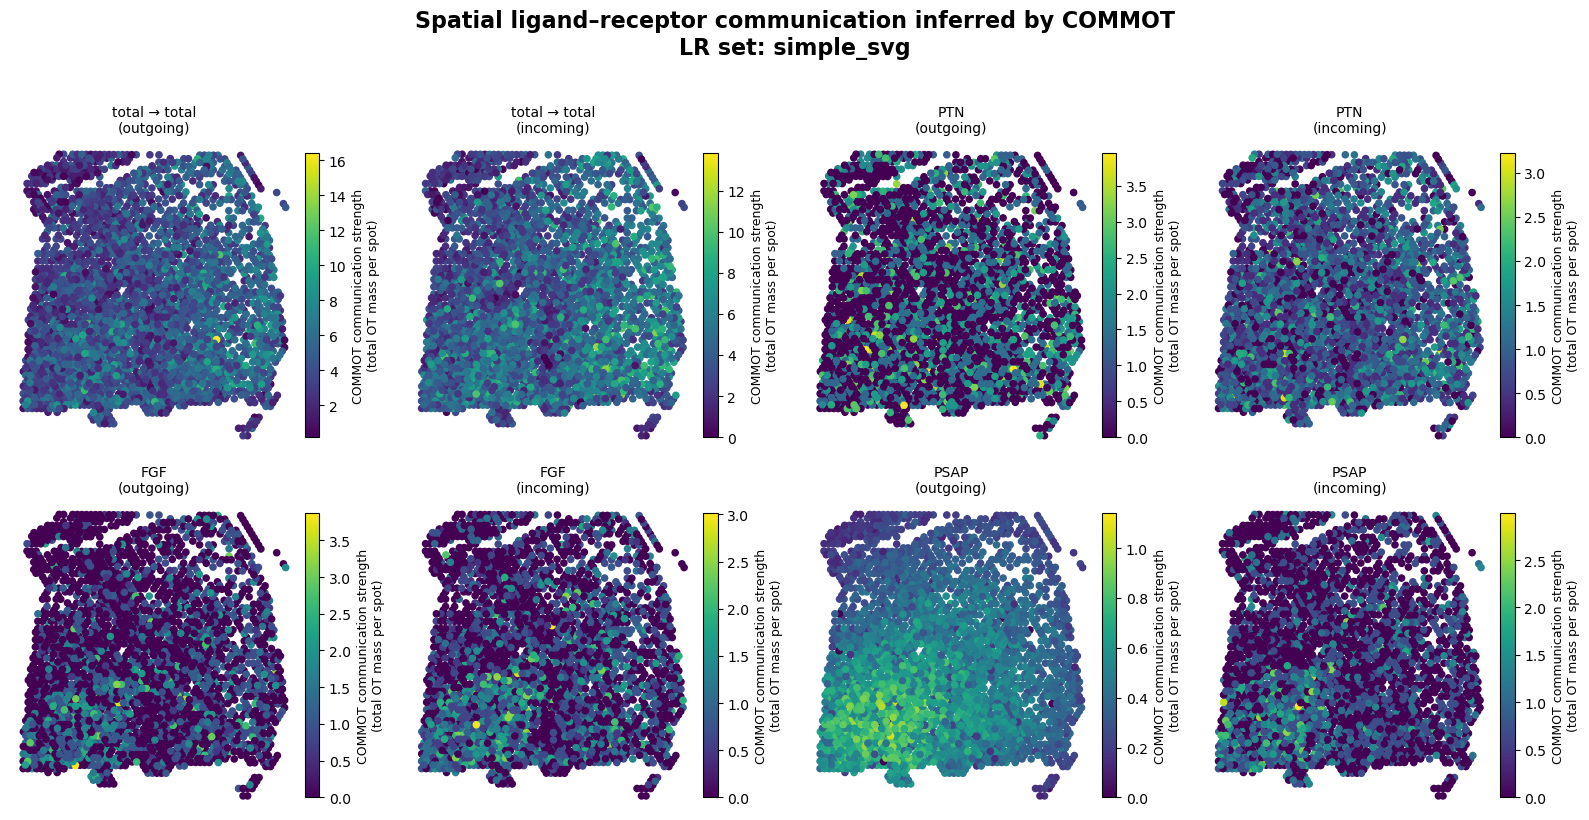

In [48]:
# plot top LR pairs for a chosen LR set
lr_set_name = "simple_svg"
ad = svg_results[lr_set_name]

# spatial coordinates
xy = ad.obsm["spatial"]

# COMMOT LR keys ranked by total communication
lr_keys = list(ad.obsp.keys())
lr_ranked = sorted(
    lr_keys,
    key=lambda k: ad.obsp[k].sum() if sparse.issparse(ad.obsp[k]) else np.sum(ad.obsp[k]),
    reverse=True
)

# choose top 4 LR pairs
top_lr = lr_ranked[:4]

# plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

panel = 0

for lr_key in top_lr:
    # sender / receiver values
    M = ad.obsp[lr_key]
    out_vals = np.array(M.sum(axis=1)).ravel()
    in_vals  = np.array(M.sum(axis=0)).ravel()

    lr_pretty = lr_key.replace("commot-cellchat-", "").replace("-", " → ", 1)

    for vals, direction in [(out_vals, "outgoing"), (in_vals, "incoming")]:
        ax = axes[panel]

        sca = ax.scatter(
            xy[:, 0],
            xy[:, 1],
            c=vals,
            s=20,
            cmap="viridis"
        )
        ax.invert_yaxis()
        ax.set_title(f"{lr_pretty}\n({direction})", fontsize=10)
        ax.axis("off")

        # colorbar
        cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
        cbar.set_label(
            "COMMOT communication strength\n(total OT mass per spot)",
            fontsize=9
        )

        panel += 1

fig.suptitle(
    "Spatial ligand–receptor communication inferred by COMMOT\n"
    f"LR set: {lr_set_name}",
    fontsize=16,
    fontweight='bold',
    y=1.02
)

plt.tight_layout()
plt.show()

Spot colors indicate the OT mass for sender and reciever spots.

OT mass is a relative, unitless measurement -> reflects signaling flow

closer LRs = more mass (cheaper transport) = spatially probable signaling

farther LRs = less mass = spatially contraint signaling

In [ ]:
# summary table for SVG LR sets
svg_tbl = top_totals_table(svg_results, top_n=20)
svg_tbl.style.format("{:.2e}")

,simple_svg,LR_svg,L_svg,R_svg,prevalence_svg
commot-cellchat-total-total,1.27e+04,6.41e+03,9.19e+03,1.02e+04,1.10e+04
commot-cellchat-PTN,2.41e+03,2.31e+03,2.51e+03,2.22e+03,2.40e+03
commot-cellchat-FGF,1.56e+03,8.26e+02,9.39e+02,1.44e+03,1.37e+03
commot-cellchat-PSAP,1.36e+03,1.36e+03,1.36e+03,1.36e+03,1.36e+03
commot-cellchat-PSAP-GPR37L1,8.34e+02,8.34e+02,8.34e+02,8.34e+02,8.34e+02
commot-cellchat-PTN-NCL,8.17e+02,8.56e+02,8.32e+02,8.42e+02,8.18e+02
commot-cellchat-SEMATOSTATIN,8.01e+02,4.41e+02,8.01e+02,4.41e+02,7.27e+02
commot-cellchat-GAS,7.28e+02,5.82e+02,7.28e+02,5.82e+02,6.90e+02
commot-cellchat-PTN-SDC3,6.12e+02,6.58e+02,6.41e+02,6.29e+02,6.13e+02
commot-cellchat-SEMA3,6.02e+02,0.00e+00,1.39e+02,5.66e+02,5.29e+02


### Top pathways for SVGs:
**higher OT mass = spatial organization of LR spots allows for more signaling flow assuming OT model**

- PTN
    - pleiotrophin (PTN) binds a tyrosine phosphatase receptor to trigger downstream pathway activation of IRS-1, AKT, ERK, STAT3, Wnt, etc. for cell growth, neural development, angiogenesis, and others.
    - involved in neural migration, differentiation, synaptic plasticity, neuroprotection, and etc.

- FGF
    - fibroblast growth factor (FGF) bind to FGF receptors to trigger downstream pathways like MAPK for cell growth differentiation, and stem cell pluripotency
    - involved in neurogenesis, myelination, synapse formation, and metabolism in neural tissue

- PSAP
    - prosaposin protein (PSAP) processing saposins (glycoproteins) for lysosomal lipid degredation and activation of other pathways such as ERK & PI3K-Akt for cell proliferation
    - linked to glioma cell proliferaton (abnormal glial cells)

- Psap-Gpr37l1
    - involves PSAP -> activates g-protein coupled receptors GPR37 and GPR37L1 to initiate downstream pathways like ERK and cAMP activation
    - involved in astrocyte migration and neuroprotection

- PTN-NCL
    - pleiotropin (PTN) binds nucleolin (NCL) receptor to trigger cell responses like migration, proliferation, and repair. 
    - involved in neural development, neurogenesis, and neural stem cell proliferation

### SVG Null model (shuffled coords)

In [60]:
# null model testing with COMMOT
# shuffle spot locations and rerun COMMOT
n_shuffles = 5
null_svg_results = defaultdict(list)
for name, df in svg_lr_sets.items():
    print("Null model for LR set:", name)
    for i in range(n_shuffles):
        print(" Shuffle", i+1)
        ad = adata.copy()
        # shuffle spatial coordinates
        shuffled_xy = ad.obsm["spatial"].copy()
        np.random.shuffle(shuffled_xy)
        ad.obsm["spatial"] = shuffled_xy
        # run COMMOT
        ct.tl.spatial_communication(
            adata=ad,
            database_name="cellchat",
            df_ligrec=df,
            dis_thr=500,
            heteromeric=True,
            pathway_sum=True,
        )
        null_svg_results[name].append(ad)

Null model for LR set: simple_svg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: LR_svg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: L_svg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: R_svg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5
Null model for LR set: prevalence_svg
 Shuffle 1
 Shuffle 2
 Shuffle 3
 Shuffle 4
 Shuffle 5


In [61]:
# save null models
output_dir_null = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets_null"
os.makedirs(output_dir_null, exist_ok=True)
for name, ad_list in null_svg_results.items():
    for i, ad in enumerate(ad_list):
        output_path = os.path.join(output_dir_null, f"human_commot_{name}_null_{i+1}.h5ad")
        ad.write_h5ad(output_path)
        print(f"Saved null {name} shuffle {i+1} results to {output_path}")

Saved null simple_svg shuffle 1 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets_null/human_commot_simple_svg_null_1.h5ad
Saved null simple_svg shuffle 2 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets_null/human_commot_simple_svg_null_2.h5ad
Saved null simple_svg shuffle 3 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets_null/human_commot_simple_svg_null_3.h5ad
Saved null simple_svg shuffle 4 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets_null/human_commot_simple_svg_null_4.h5ad
Saved null simple_svg shuffle 5 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets_null/human_commot_simple_svg_null_5.h5ad
Saved null LR_svg shuffle 1 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_svg_lr_sets_null/human_commot_LR_svg_null_1.h5ad


In [62]:
# check null results
print("Null model COMMOT results for SVG LR sets:")
for name, ad_list in null_svg_results.items():
    print("\n==", name, "==")
    for i, ad in enumerate(ad_list):
        inv = commot_inventory(ad)
        print(f" Shuffle {i+1}: n_obsp: {inv['n_obsp']}, obsp head: {inv['obsp_keys_head']}")

Null model COMMOT results for SVG LR sets:

== simple_svg ==
 Shuffle 1: n_obsp: 236, obsp head: ['commot-cellchat-SEMA3E-PLXND1', 'commot-cellchat-WNT7B-FZD3_LRP5', 'commot-cellchat-WNT7B-FZD3_LRP6', 'commot-cellchat-TGFB2-ACVR1B_TGFBR2', 'commot-cellchat-WNT7A-FZD3_LRP5', 'commot-cellchat-WNT7A-FZD3_LRP6', 'commot-cellchat-MIF-ACKR3', 'commot-cellchat-MIF-CD74_CD44', 'commot-cellchat-MIF-CD74_CXCR4', 'commot-cellchat-WNT10A-FZD3_LRP5', 'commot-cellchat-WNT10A-FZD3_LRP6', 'commot-cellchat-PROS1-TYRO3', 'commot-cellchat-MDK-SDC4', 'commot-cellchat-MDK-ITGA6_ITGB1', 'commot-cellchat-MDK-LRP1']
 Shuffle 2: n_obsp: 236, obsp head: ['commot-cellchat-SEMA3E-PLXND1', 'commot-cellchat-WNT7B-FZD3_LRP5', 'commot-cellchat-WNT7B-FZD3_LRP6', 'commot-cellchat-TGFB2-ACVR1B_TGFBR2', 'commot-cellchat-WNT7A-FZD3_LRP5', 'commot-cellchat-WNT7A-FZD3_LRP6', 'commot-cellchat-MIF-ACKR3', 'commot-cellchat-MIF-CD74_CD44', 'commot-cellchat-MIF-CD74_CXCR4', 'commot-cellchat-WNT10A-FZD3_LRP5', 'commot-cellchat-WN

In [ ]:
# significance for SVG LR sets
print("Pathway significance for SVG LR sets:")
for name, ad in svg_results.items():
    null_ads = null_svg_results[name]
    sig_df = pathway_significance(ad, null_ads, top_n=10)
    print("\n==", name, "==")
    print(sig_df)
    

### Null Results Interpretation

- Tests if inferred CCC under COMMOT model depends on spatial organization of spots 
    - negative zscore = real tissue organization allows for less total OT mass than null -> spatial organization constrains the signalling pathway
    - positive zscore = real spatial organization allows for more total OT mass than null -> spatial organization enhances the signaling pathway

<br>

- Exremely negative z-scores (FGF) LR interaction pathways have less total OT mass than random spatial null models and are highly spatially contraint
    - Higher OT mass in null model suggests spatial structure constraints LR pathways 

- Positive z-scores (GAS) indicate the LR interaction pathways have higher signaling efficiency when spaitally organized compared to random spatial tissue arch
itecture.
    - Suggests co-localization of LR domains

***Tissue architecture can contrain or enhance signaling in pathways***

## HVGs
- simple HVGs
- L&R HVG
- ligand HVG
- receptor HVG
- 5% prevalence

In [51]:
# HVG LR sets
hvg_lr_sets = {
    "simple_hvg": lr_hvg,
    "LR_hvg" : lr_hvg_strict,
    "L_hvg" : lr_hvg_ligand,
    "R_hvg" : lr_hvg_receptor,
    "prevalence_hvg" : prevalence_lr_hvg,
}

hvg_results = {}

# run COMMOT for each LR set
for name, df in hvg_lr_sets.items():
    ad = adata.copy()  # use shallow copy
    ct.tl.spatial_communication(
        adata=ad,
        database_name="cellchat",
        df_ligrec=df,
        dis_thr=500,
        heteromeric=True,
        pathway_sum=True,
    )
    hvg_results[name] = ad

print(hvg_results.keys())

dict_keys(['simple_hvg', 'LR_hvg', 'L_hvg', 'R_hvg', 'prevalence_hvg'])


In [52]:
# look at results
print("COMMOT results for HVG LR sets:")
for name, ad in hvg_results.items():
    inv = commot_inventory(ad)
    print("\n==", name, "==")
    print("n_obsp:", inv["n_obsp"])
    print("obsp head:", inv["obsp_keys_head"])

COMMOT results for HVG LR sets:

== simple_hvg ==
n_obsp: 502
obsp head: ['commot-cellchat-SEMA3E-PLXND1', 'commot-cellchat-WNT7B-FZD10_LRP6', 'commot-cellchat-WNT7B-FZD3_LRP5', 'commot-cellchat-WNT7B-FZD8_LRP6', 'commot-cellchat-WNT7B-FZD6_LRP6', 'commot-cellchat-WNT7B-FZD1_LRP6', 'commot-cellchat-WNT7B-FZD5_LRP6', 'commot-cellchat-WNT7B-FZD3_LRP6', 'commot-cellchat-WNT7B-FZD7_LRP6', 'commot-cellchat-WNT7B-FZD2_LRP6', 'commot-cellchat-WNT7B-FZD4_LRP6', 'commot-cellchat-WNT7B-FZD9_LRP6', 'commot-cellchat-PGF-FLT1', 'commot-cellchat-TGFB2-TGFBR1_TGFBR2', 'commot-cellchat-TGFB2-ACVR1_TGFBR1_TGFBR2']

== LR_hvg ==
n_obsp: 148
obsp head: ['commot-cellchat-SEMA3E-PLXND1', 'commot-cellchat-APLN-APLNR', 'commot-cellchat-SEMA3B-NRP1_PLXNA1', 'commot-cellchat-SEMA3B-NRP1_PLXNA3', 'commot-cellchat-SEMA3B-NRP2_PLXNA1', 'commot-cellchat-SEMA3B-NRP2_PLXNA2', 'commot-cellchat-SEMA3B-NRP2_PLXNA3', 'commot-cellchat-SEMA3B-NRP1_PLXNA4', 'commot-cellchat-SEMA3B-NRP2_PLXNA4', 'commot-cellchat-SEMA3B-NRP1

In [53]:
# save results
output_dir = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets"
os.makedirs(output_dir, exist_ok=True)
for name, ad in svg_results.items():
    output_path = os.path.join(output_dir, f"human_commot_{name}.h5ad")
    ad.write_h5ad(output_path)
    print(f"Saved {name} results to {output_path}")

Saved simple_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets/human_commot_simple_svg.h5ad
Saved LR_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets/human_commot_LR_svg.h5ad
Saved L_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets/human_commot_L_svg.h5ad
Saved R_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets/human_commot_R_svg.h5ad
Saved prevalence_svg results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets/human_commot_prevalence_svg.h5ad


In [54]:
# pathway-sum matrices vs LR pair matrices
print("Pathway vs LR matrices for HVG LR sets:")
for name, ad in  hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    print(name, "path:", len(pk), "lr:", len(lk))

Pathway vs LR matrices for HVG LR sets:
simple_hvg path: 0 lr: 502
LR_hvg path: 0 lr: 148
L_hvg path: 0 lr: 249
R_hvg path: 0 lr: 435
prevalence_hvg path: 0 lr: 155


In [55]:
# rank pathways by total communication strength
print("Top pathways by total communication strength for HVG LR sets:")
for name, ad in hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top = rank_obsp_by_total(ad, keys_to_rank)[:10]
    print("\nTOP in", name)
    for k, s in top:
        print(f"{s: .3e}", k)

Top pathways by total communication strength for HVG LR sets:

TOP in simple_hvg
 1.519e+04 commot-cellchat-total-total
 2.393e+03 commot-cellchat-PTN
 1.682e+03 commot-cellchat-FGF
 1.362e+03 commot-cellchat-PSAP
 8.343e+02 commot-cellchat-PSAP-GPR37L1
 8.164e+02 commot-cellchat-PTN-NCL
 8.014e+02 commot-cellchat-SEMATOSTATIN
 7.243e+02 commot-cellchat-GAS
 6.332e+02 commot-cellchat-SEMA3
 6.144e+02 commot-cellchat-PTN-SDC3

TOP in LR_hvg
 1.283e+04 commot-cellchat-total-total
 2.382e+03 commot-cellchat-PTN
 1.549e+03 commot-cellchat-FGF
 1.362e+03 commot-cellchat-PSAP
 8.343e+02 commot-cellchat-PSAP-GPR37L1
 8.178e+02 commot-cellchat-PTN-NCL
 7.266e+02 commot-cellchat-SEMATOSTATIN
 6.902e+02 commot-cellchat-GAS
 6.153e+02 commot-cellchat-PTN-SDC3
 6.077e+02 commot-cellchat-SEMA3

TOP in L_hvg
 1.384e+04 commot-cellchat-total-total
 2.393e+03 commot-cellchat-PTN
 1.549e+03 commot-cellchat-FGF
 1.362e+03 commot-cellchat-PSAP
 8.343e+02 commot-cellchat-PSAP-GPR37L1
 8.164e+02 commot-cel

In [56]:
# per spot sender and receiver scores for top pathway in each HVG LR set
print("Adding top 3 sender/receiver scores for HVG LR sets")
for name, ad in hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top3 = [k for k, _ in rank_obsp_by_total(ad, keys_to_rank)[:3]]
    for i, k in enumerate(top3, 1):
        add_sender_receiver(ad, k, prefix=f"{name}_top{i}")

Adding top 3 sender/receiver scores for HVG LR sets


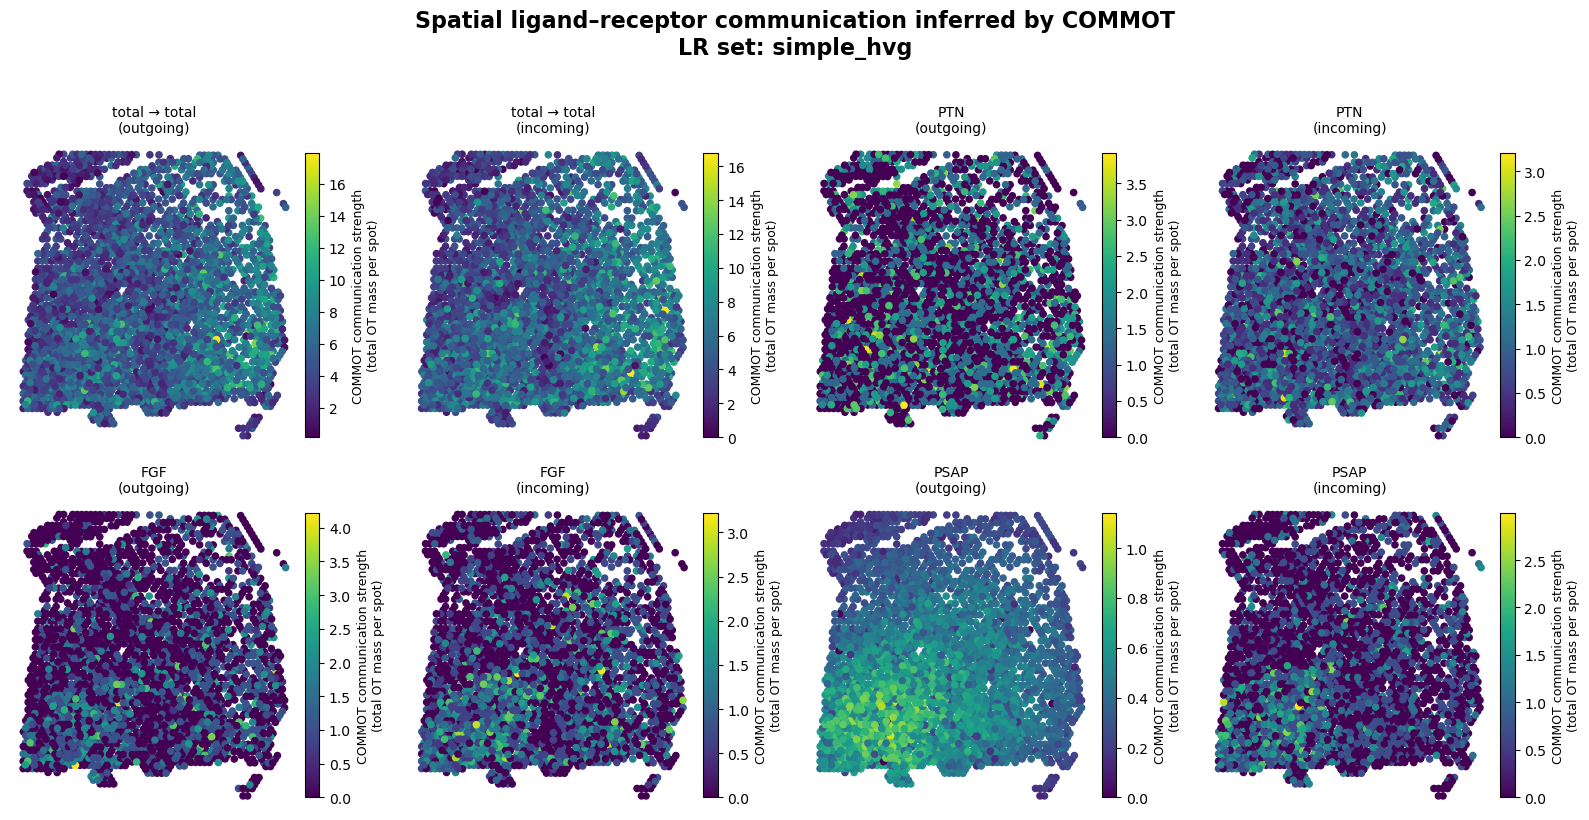

In [57]:
# plot top LR pairs for a chosen LR set
lr_set_name = "simple_hvg"
ad = hvg_results[lr_set_name]

# spatial coordinates
xy = ad.obsm["spatial"]

# COMMOT LR keys ranked by total communication
lr_keys = list(ad.obsp.keys())
lr_ranked = sorted(
    lr_keys,
    key=lambda k: ad.obsp[k].sum() if sparse.issparse(ad.obsp[k]) else np.sum(ad.obsp[k]),
    reverse=True
)

# choose top 4 LR pairs
top_lr = lr_ranked[:4]

# plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

panel = 0

for lr_key in top_lr:
    # sender / receiver values
    M = ad.obsp[lr_key]
    out_vals = np.array(M.sum(axis=1)).ravel()
    in_vals  = np.array(M.sum(axis=0)).ravel()

    lr_pretty = lr_key.replace("commot-cellchat-", "").replace("-", " → ", 1)

    for vals, direction in [(out_vals, "outgoing"), (in_vals, "incoming")]:
        ax = axes[panel]

        sca = ax.scatter(
            xy[:, 0],
            xy[:, 1],
            c=vals,
            s=20,
            cmap="viridis"
        )
        ax.invert_yaxis()
        ax.set_title(f"{lr_pretty}\n({direction})", fontsize=10)
        ax.axis("off")

        # colorbar
        cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
        cbar.set_label(
            "COMMOT communication strength\n(total OT mass per spot)",
            fontsize=9
        )

        panel += 1

fig.suptitle(
    "Spatial ligand–receptor communication inferred by COMMOT\n"
    f"LR set: {lr_set_name}",
    fontsize=16,
    fontweight='bold',
    y=1.02
)

plt.tight_layout()
plt.show()

In [58]:
# summary table for HVG LR sets
hvg_tbl = top_totals_table(hvg_results, top_n=20)
hvg_tbl.style.format("{:.2e}")

,simple_hvg,LR_hvg,L_hvg,R_hvg,prevalence_hvg
commot-cellchat-total-total,1.52e+04,1.28e+04,1.38e+04,1.43e+04,1.24e+04
commot-cellchat-PTN,2.39e+03,2.38e+03,2.39e+03,2.38e+03,2.38e+03
commot-cellchat-FGF,1.68e+03,1.55e+03,1.55e+03,1.68e+03,1.46e+03
commot-cellchat-PSAP,1.36e+03,1.36e+03,1.36e+03,1.36e+03,1.36e+03
commot-cellchat-PSAP-GPR37L1,8.34e+02,8.34e+02,8.34e+02,8.34e+02,8.34e+02
commot-cellchat-PTN-NCL,8.16e+02,8.18e+02,8.16e+02,8.18e+02,8.18e+02
commot-cellchat-SEMATOSTATIN,8.01e+02,7.27e+02,8.01e+02,7.27e+02,7.27e+02
commot-cellchat-GAS,7.24e+02,6.90e+02,7.28e+02,6.87e+02,6.90e+02
commot-cellchat-SEMA3,6.33e+02,6.08e+02,6.08e+02,6.33e+02,5.38e+02
commot-cellchat-PTN-SDC3,6.14e+02,6.15e+02,6.14e+02,6.15e+02,6.15e+02


### Top pathways for HVGs:
- PTN
- FGF
- PSAP
- Psap-Gpr37l1
- PTN-NCL

**same as SVGs**

### HVG Null model (shuffled coords):

In [42]:
# load in hvg lr sets
real_results_dir = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets"
real_model_files = [f for f in os.listdir(real_results_dir) if f.endswith(".h5ad")]

real_results = {}
for f in real_model_files:
    ad = sc.read_h5ad(os.path.join(real_results_dir, f))
    name = f.replace("human_commot_", "").replace(".h5ad", "")
    real_results[name] = ad
    print("Loaded real COMMOT results:", name, ad.shape)


hvg_lr_sets = {
    "simple_hvg": lr_hvg,
    "LR_hvg": lr_hvg_strict,
    "L_hvg": lr_hvg_ligand,
    "R_hvg": lr_hvg_receptor,
    "prevalence_hvg": prevalence_lr_hvg,
}



Loaded real COMMOT results: simple_hvg (2897, 17650)
Loaded real COMMOT results: L_hvg (2897, 17650)
Loaded real COMMOT results: prevalence_hvg (2897, 17650)
Loaded real COMMOT results: R_hvg (2897, 17650)
Loaded real COMMOT results: LR_hvg (2897, 17650)


In [47]:
# fix attempt 2 -> don't copy adata and only extract pathway level totals 
# only do 3 shuffles
# run one hvg LR set at a time

n_shuffles = 3
null_pathway_totals = defaultdict(list)

orig_xy = adata.obsm["spatial"].copy()
rng = np.random.default_rng(0)

output_dir_null = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets_null"
os.makedirs(output_dir_null, exist_ok=True)

# run one hvg LR set at a time
target_name = "prevalence_hvg"   #  change
df = hvg_lr_sets[target_name]

print("Null model for LR set:", target_name, "LR pairs:", len(df))
for i in range(n_shuffles):
    print(" Shuffle", i + 1)

    before = snapshot_keys(adata)

    perm = rng.permutation(orig_xy.shape[0])
    adata.obsm["spatial"] = orig_xy[perm]

    ct.tl.spatial_communication(
        adata=adata,
        database_name="cellchat",
        df_ligrec=df,
        dis_thr=500,
        heteromeric=True,
        pathway_sum=True,
    )

    after = snapshot_keys(adata)
    new_obsp = sorted(after["obsp"] - before["obsp"])

    totals = sum_pathways_from_new_obsp(adata, new_obsp, db="cellchat")
    null_pathway_totals[target_name].append(totals)

    output_path = os.path.join(
    output_dir_null,
    f"human_commot_{target_name}_null_{i+1}.h5ad")

    adata.write_h5ad(output_path)
    print(f"Saved null {target_name} shuffle {i+1} results to {output_path}")


    cleanup_added(adata, before)

adata.obsm["spatial"] = orig_xy



Null model for LR set: prevalence_hvg LR pairs: 131
 Shuffle 1
Saved null prevalence_hvg shuffle 1 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets_null/mouse_commot_prevalence_hvg_null_1.h5ad
 Shuffle 2
Saved null prevalence_hvg shuffle 2 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets_null/mouse_commot_prevalence_hvg_null_2.h5ad
 Shuffle 3
Saved null prevalence_hvg shuffle 3 results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets_null/mouse_commot_prevalence_hvg_null_3.h5ad


In [67]:
# load in null models and organize
null_results_dir = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets_null"
null_hvg_files = [f for f in os.listdir(null_results_dir) if f.endswith(".h5ad")]

# organize null results by LR set name
null_hvg_results = defaultdict(list)
for f in null_hvg_files:
    # get LR set name from filename
    # file name format: human_commot_{lr_set_name}_null_{shuffle_num}.h5ad
    parts = f.replace("human_commot_", "").replace(".h5ad", "").split("_null_")
    if len(parts) == 2:
        lr_set_name = parts[0]
        ad = sc.read_h5ad(os.path.join(null_results_dir, f))
        null_hvg_results[lr_set_name].append(ad)
        print(f"Loaded null result: {lr_set_name}, shuffle {parts[1]}")

print(f"null results for LR sets: {list(null_hvg_results.keys())}")

Loaded null result: LR_hvg, shuffle 1
Loaded null result: mouse_commot_L_hvg, shuffle 3
Loaded null result: mouse_commot_L_hvg, shuffle 2
Loaded null result: mouse_commot_R_hvg, shuffle 1
Loaded null result: mouse_commot_prevalence_hvg, shuffle 2
Loaded null result: mouse_commot_prevalence_hvg, shuffle 3
Loaded null result: mouse_commot_simple_hvg, shuffle 1
Loaded null result: mouse_commot_R_hvg, shuffle 3
Loaded null result: mouse_commot_simple_hvg, shuffle 2
Loaded null result: mouse_commot_simple_hvg, shuffle 3
Loaded null result: mouse_commot_prevalence_hvg, shuffle 1
Loaded null result: mouse_commot_R_hvg, shuffle 2
Loaded null result: mouse_commot_L_hvg, shuffle 1
Loaded null result: LR_hvg, shuffle 3
Loaded null result: LR_hvg, shuffle 2
null results for LR sets: ['LR_hvg', 'mouse_commot_L_hvg', 'mouse_commot_R_hvg', 'mouse_commot_prevalence_hvg', 'mouse_commot_simple_hvg']


In [69]:
# load in hvg results
input_dir = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets"

svg_results = {}

for fname in os.listdir(input_dir):
    if fname.endswith(".h5ad"):
        # extract the key name (inverse of your save convention)
        # human_commot_{name}.h5ad
        name = fname.replace("human_commot_", "").replace(".h5ad", "")
        
        path = os.path.join(input_dir, fname)
        ad = sc.read_h5ad(path)
        
        svg_results[name] = ad
        print(f"Loaded {name} from {path}")

Loaded simple_hvg from /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets/human_commot_simple_hvg.h5ad
Loaded L_hvg from /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets/human_commot_L_hvg.h5ad
Loaded prevalence_hvg from /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets/human_commot_prevalence_hvg.h5ad
Loaded R_hvg from /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets/human_commot_R_hvg.h5ad
Loaded LR_hvg from /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_hvg_lr_sets/human_commot_LR_hvg.h5ad


In [77]:
# significance for HVG LR sets
print("Pathway significance for HVG LR sets:")
for name, ad in hvg_results.items():
    null_ads = null_hvg_results[name]
    sig_df = pathway_significance(ad, null_ads, top_n=10)
    print("\n==", name, "==")
    print(sig_df)

Pathway significance for HVG LR sets:

== simple_hvg ==
                        pathway    real_total  mean_null_total  \
0   commot-cellchat-total-total  12676.560793              NaN   
1           commot-cellchat-PTN   2412.818032              NaN   
2           commot-cellchat-FGF   1558.076196              NaN   
3          commot-cellchat-PSAP   1361.542053              NaN   
4  commot-cellchat-PSAP-GPR37L1    834.327803              NaN   
5       commot-cellchat-PTN-NCL    816.709314              NaN   
6  commot-cellchat-SEMATOSTATIN    801.394047              NaN   
7           commot-cellchat-GAS    727.724924              NaN   
8      commot-cellchat-PTN-SDC3    611.993863              NaN   
9         commot-cellchat-SEMA3    601.510010              NaN   

   std_null_total  z_score  
0             NaN      inf  
1             NaN      inf  
2             NaN      inf  
3             NaN      inf  
4             NaN      inf  
5             NaN      inf  
6             

### Null Results Interpretaion

For LR_hvgs, the total pathway, PTN, FGF, and GAS had negative z scores, indicating these pathways are spatially constraint.
Pathways including PTN-NCL, PTN-SDC3, and GAS6-TYRO3 had substantially positive z scores, indicating these pathways are enhanced by spatial organization contraints.

**Consistent conclusion: tissue architecture con constrain or enhance signaling pathways**

## Unfiltered genes

In [113]:
# commot for unfiltered LR pairs
lr_unfiltered = lr_expr.copy()   

unfiltered_results = {}

name = "unfiltered_lr"
ad = adata.copy()

ct.tl.spatial_communication(
    adata=ad,
    database_name="cellchat",
    df_ligrec=lr_unfiltered,
    dis_thr=500,
    heteromeric=True,
    pathway_sum=True,
)

unfiltered_results[name] = ad
print(unfiltered_results.keys())

# save results
output_dir = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_unfiltered_lr"
os.makedirs(output_dir, exist_ok=True)
for name, ad in unfiltered_results.items():
    output_path = os.path.join(output_dir, f"human_commot_{name}.h5ad")
    ad.write_h5ad(output_path)
    print(f"Saved {name} results to {output_path}")


dict_keys(['unfiltered_lr'])
Saved unfiltered_lr results to /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_unfiltered_lr/human_commot_unfiltered_lr.h5ad


In [114]:
# load in unfiltered lr results
input_dir = "/Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_unfiltered_lr"
unfiltered_results = {}
for fname in os.listdir(input_dir):
    if fname.endswith(".h5ad"):
        # extract the key name (inverse of your save convention)
        # human_commot_{name}.h5ad
        name = fname.replace("human_commot_", "").replace(".h5ad", "")
        
        path = os.path.join(input_dir, fname)
        ad = sc.read_h5ad(path)
        
        unfiltered_results[name] = ad
        print(f"Loaded {name} from {path}")

Loaded unfiltered_lr from /Users/emilyekstrum/repos/zhangLab_Rotation/data/processed/COMMOT/human_unfiltered_lr/human_commot_unfiltered_lr.h5ad


In [55]:
# look at results
print("COMMOT results for unfiltered LR sets:")
for name, ad in unfiltered_results.items():
    inv = commot_inventory(ad)
    print("\n==", name, "==")
    print("n_obsp:", inv["n_obsp"])
    print("obsp head:", inv["obsp_keys_head"])

COMMOT results for unfiltered LR sets:

== unfiltered_lr ==
n_obsp: 720
obsp head: ['commot-cellchat-FGF5-FGFR2', 'commot-cellchat-FGF5-FGFR4', 'commot-cellchat-FGF5-FGFR1', 'commot-cellchat-FGF5-FGFR3', 'commot-cellchat-BMP8A-BMPR1A_BMPR2', 'commot-cellchat-BMP8A-ACVR1_BMPR2', 'commot-cellchat-BMP8A-BMPR1A_ACVR2A', 'commot-cellchat-BMP8A-BMPR1B_ACVR2B', 'commot-cellchat-BMP8A-BMPR1B_BMPR2', 'commot-cellchat-BMP8A-BMPR1A_ACVR2B', 'commot-cellchat-BMP8A-ACVR1_ACVR2B', 'commot-cellchat-BMP8A-BMPR1B_ACVR2A', 'commot-cellchat-BMP8A-ACVR1_ACVR2A', 'commot-cellchat-TNFSF12-TNFRSF12A', 'commot-cellchat-ADIPOQ-ADIPOR1']


In [115]:
# pathway-sum matrices vs LR pair matrices
print("Pathway vs LR matrices for unfiltered LR sets:")
for name, ad in  hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    print(name, "path:", len(pk), "lr:", len(lk))

Pathway vs LR matrices for unfiltered LR sets:
simple_hvg path: 0 lr: 236
L_hvg path: 0 lr: 86
prevalence_hvg path: 0 lr: 103
R_hvg path: 0 lr: 186
LR_hvg path: 0 lr: 23


In [116]:
# per spot sender and receiver scores for top pathway in unfiltered LR set
print("Adding top 3 sender/receiver scores for unfiltered LR set")
for name, ad in hvg_results.items():
    pk, lk = split_pathway_lr_keys(ad)
    keys_to_rank = pk if len(pk) > 0 else lk
    top3 = [k for k, _ in rank_obsp_by_total(ad, keys_to_rank)[:3]]
    for i, k in enumerate(top3, 1):
        add_sender_receiver(ad, k, prefix=f"{name}_top{i}")

Adding top 3 sender/receiver scores for unfiltered LR set


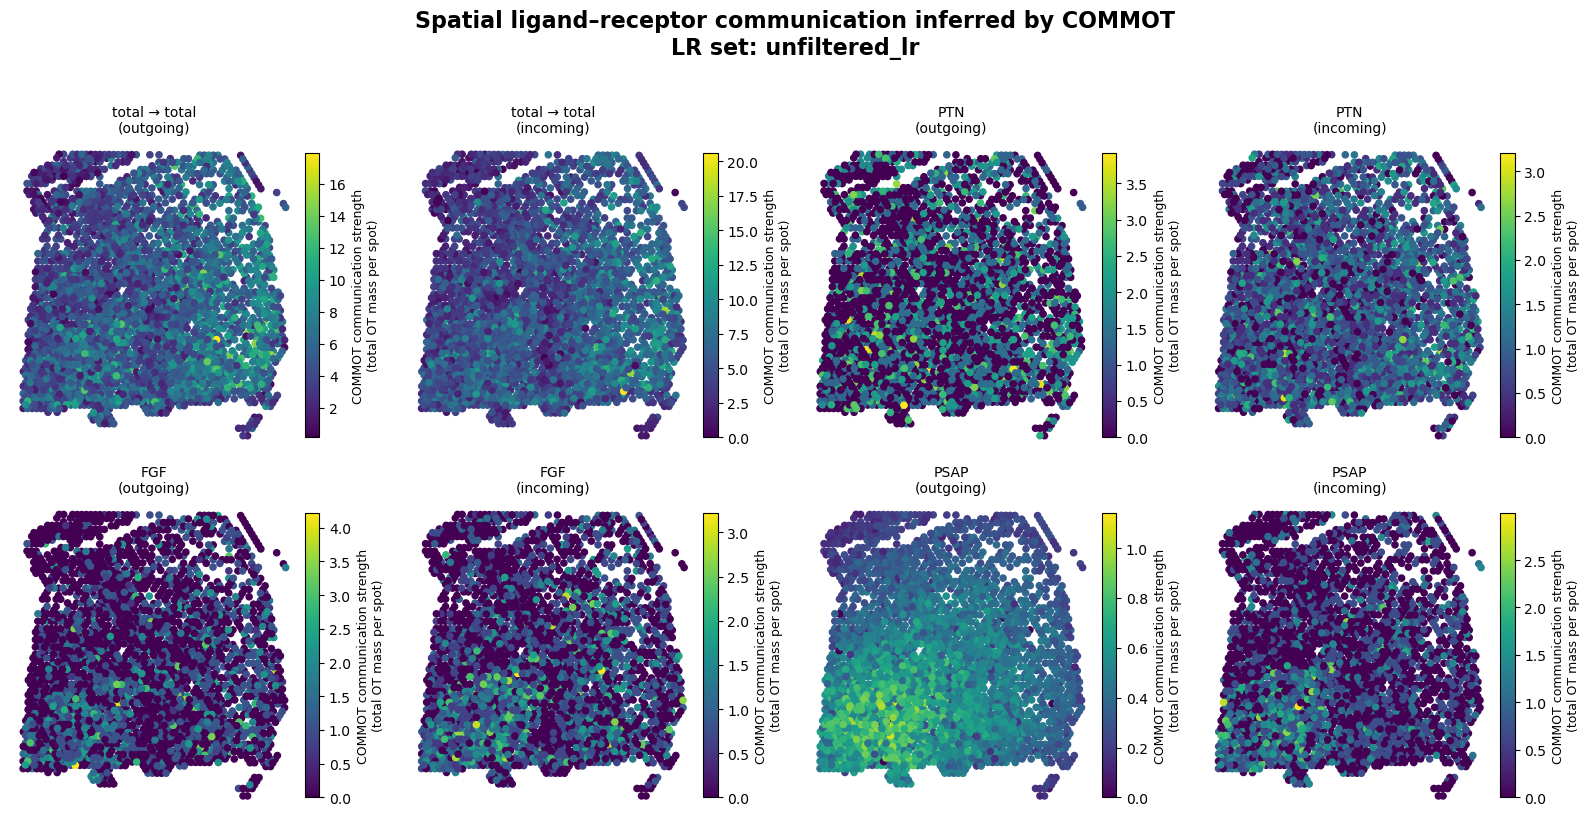

In [117]:
# plot top LR pairs for a chosen LR set
lr_set_name = "unfiltered_lr"
ad = unfiltered_results[lr_set_name]

# spatial coordinates
xy = ad.obsm["spatial"]

# COMMOT LR keys ranked by total communication
lr_keys = list(ad.obsp.keys())
lr_ranked = sorted(
    lr_keys,
    key=lambda k: ad.obsp[k].sum() if sparse.issparse(ad.obsp[k]) else np.sum(ad.obsp[k]),
    reverse=True
)

# choose top 4 LR pairs
top_lr = lr_ranked[:4]

# plot
fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

panel = 0

for lr_key in top_lr:
    # sender / receiver values
    M = ad.obsp[lr_key]
    out_vals = np.array(M.sum(axis=1)).ravel()
    in_vals  = np.array(M.sum(axis=0)).ravel()

    lr_pretty = lr_key.replace("commot-cellchat-", "").replace("-", " → ", 1)

    for vals, direction in [(out_vals, "outgoing"), (in_vals, "incoming")]:
        ax = axes[panel]

        sca = ax.scatter(
            xy[:, 0],
            xy[:, 1],
            c=vals,
            s=20,
            cmap="viridis"
        )
        ax.invert_yaxis()
        ax.set_title(f"{lr_pretty}\n({direction})", fontsize=10)
        ax.axis("off")

        # colorbar
        cbar = fig.colorbar(sca, ax=ax, fraction=0.046, pad=0.02)
        cbar.set_label(
            "COMMOT communication strength\n(total OT mass per spot)",
            fontsize=9
        )

        panel += 1

fig.suptitle(
    "Spatial ligand–receptor communication inferred by COMMOT\n"
    f"LR set: {lr_set_name}",
    fontsize=16,
    fontweight='bold',
    y=1.02
)

plt.tight_layout()
plt.show()

In [118]:
# summary table for unfiltered LR sets
unfilt_tbl = top_totals_table(unfiltered_results, top_n=20)
unfilt_tbl.style.format("{:.2e}")

,unfiltered_lr
commot-cellchat-total-total,1.57e+04
commot-cellchat-PTN,2.39e+03
commot-cellchat-FGF,1.68e+03
commot-cellchat-PSAP,1.36e+03
commot-cellchat-PSAP-GPR37L1,8.34e+02
commot-cellchat-PTN-NCL,8.16e+02
commot-cellchat-SEMATOSTATIN,8.01e+02
commot-cellchat-GAS,7.24e+02
commot-cellchat-SEMA3,6.33e+02
commot-cellchat-PTN-SDC3,6.14e+02


Similar top pathways compared to SVGs and HVGs.